<a href="https://colab.research.google.com/github/techpvk/techpvk/blob/master/resent50_custom_3In1_meetpvk_working_23_03_of_Vkt_TinyImageNet_StarterNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# List and Clear the Data first
!ls
!rm -rf sample_data tiny-imagenet-200	tiny-imagenet-200.zip
# list content after the clearing data
!ls
# Download the file
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
  #unzip and list
!unzip -qq 'tiny-imagenet-200.zip'
!ls
filepath="drive/app/weights.best.hdf5"

sample_data
--2019-04-01 15:21:59--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  37.8MB/s    in 7.5s    

2019-04-01 15:22:07 (31.7 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]

tiny-imagenet-200  tiny-imagenet-200.zip


In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive
!ls drive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131294 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [3]:
# import the required packages
import pandas as pd
import numpy as np
import six
from keras.preprocessing.image import ImageDataGenerator
from __future__ import division
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten,
    Dropout,
    SeparableConv2D
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import os
import cv2
from keras.layers import GlobalAveragePooling2D
from keras.models import Model, load_model, model_from_yaml
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    name = conv_params["name"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))
    def f(input):
        conv = SeparableConv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                     name=name)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))
    def f(input):
        activation = _bn_relu(input)
        return SeparableConv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = SeparableConv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)
    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f

def bottleneck_pyramid(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = SeparableConv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=(1,1))(input)

        conv_3_3_1 = _bn_relu_conv(filters=filters * 2, kernel_size=(3, 3))(conv_1_1)
        conv_3_3_2 = _bn_relu_conv(filters=filters * 4, kernel_size=(3, 3))(conv_3_3_1)
        conv_3_3_3 = _bn_relu_conv(filters=filters * 8, kernel_size=(3, 3))(conv_3_3_2)
        if is_first_block_of_first_layer:
           return _shortcut(input, conv_3_3_3)
        else:
            conv_3_3_3 = _bn_relu(conv_3_3_3)
            conv_max_pool = MaxPooling2D(pool_size=(2, 2))(conv_3_3_3)
            residual = _bn_relu(conv_max_pool)
            #residual = _bn_relu_conv(filters=filters * 8, kernel_size=(3, 3))(conv_3_3_2)
            return _shortcut(input, residual)
          
    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.image_dim_ordering() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])
        # Load function from str if needed.
        block_fn = _get_block(block_fn)
        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(3, 3), strides=(1, 1),name='init-2d')(input)
        #pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)
        #x = Dropout(0.5)(pool1)
        #block = conv1
        block = input
        filters = 32
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        #block_shape = K.int_shape(block)
        #pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
        #                         strides=(1, 1))(block)
        #flatten1 = Flatten()(pool2)
        #x = Dropout(0.5)(flatten1)
        #dense = Dense(units=num_outputs, kernel_initializer="he_normal",
        #              activation="softmax")(x)
        x = Conv2D(200, (1,1), strides=(1,1), padding='same', name='final2d', use_bias=False)(block)
        x = _bn_relu(x)
        x = GlobalAveragePooling2D(data_format='channels_last')(x)
        # out = Flatten()(x)
        out = Activation('softmax') (x)
        model = Model(inputs=input, outputs=out)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])
      
    @staticmethod
    def build_resnet_50_pyramid(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck_pyramid, [1, 1, 1, 1])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])



Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


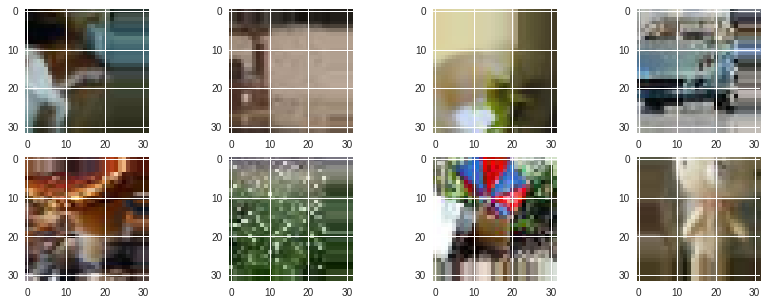

In [5]:
# load data
val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
#val_data.head(10)
# Use Augmentaion parameters as required.
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True
    )

valid_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(32, 32), color_mode='rgb', 
                                                    batch_size=200, class_mode='categorical', shuffle=True, seed=42)
validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(32, 32),
                                                    color_mode='rgb', class_mode='categorical', batch_size=200, shuffle=True, seed=42)
x_batch, y_batch = next(train_generator)
x_batch.shape
# Plot Generator images.  ** Re-run the cell to view different set of images.

fig = plt.figure(figsize=(14, 5))

for i in range(8):
    sub = fig.add_subplot(2, 4, i + 1)
    sub.imshow(x_batch[i,:,:], interpolation='nearest')

In [0]:
nb_classes = 200
#nb_epoch = 100
# input image dimensions
img_rows, img_cols = 32, 32
img_channels = 3
model = ResnetBuilder.build_resnet_50_pyramid((img_channels,img_rows,img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [0]:
plot_model(model, to_file='./tiny-imagenet-200/model_plot.png', show_shapes=True, show_layer_names=True)
from google.colab import files

files.download('./tiny-imagenet-200/model_plot.png')

In [14]:
model.summary()
#model.fit_generator(train_generator, epochs=nb_epoch, steps_per_epoch=200, validation_steps=200, validation_data=validation_generator
##steps_per_epoch=Integer. Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch. 
#It should typically be equal to ceil(num_samples / batch_size) Optional for Sequence: if unspecified, will use the len(generator) as a number of steps.
##validation_steps=Only relevant if validation_data is a generator. Total number of steps (batches of samples) to yield from validation_data generator before stopping at the end of every epoch. 
#It should typically be equal to the number of samples of your validation dataset divided by the batch size. Optional for Sequence: if unspecified, will use the len(validation_data) as a number of steps.
##epochs: Integer. Number of epochs to train the model. An epoch is an iteration over the entire data provided, as defined by steps_per_epoch. 
#Note that in conjunction with initial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations given by epochs,
#but merely until the epoch of index epochs is reached.
#steps_per_epoch=100000/200=500
#validation_steps=10000/200=50
#nb_epoch = 100
# checkpoint
#filepath="./tiny-imagenet-200/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

nb_epoch = 20
model.fit_generator(train_generator, epochs=nb_epoch, steps_per_epoch=500, validation_steps=50, validation_data=validation_generator, callbacks=callbacks_list)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_21 (SeparableC (None, 32, 32, 32)   131         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 32, 32, 32)   128         separable_conv2d_21[0][0]        
__________________________________________________________________________________________________
activation_27 (Activation)      (None, 32, 32, 32)   0           batch_normalization_26[0][0]     
__________________________________________________________________________________________________
separable_

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 1/5
500/500 [==============================] - 367s 733ms/step - loss: 2.6405 - acc: 0.3782 - val_loss: 3.4379 - val_acc: 0.3028

Epoch 00001: val_acc improved from -inf to 0.30280, saving model to drive/app/weights.best.hdf5
Epoch 2/5
500/500 [==============================] - 349s 698ms/step - loss: 2.1867 - acc: 0.4573 - val_loss: 3.3070 - val_acc: 0.3269

Epoch 00002: val_acc improved from 0.30280 to 0.32690, saving model to drive/app/weights.best.hdf5
Epoch 3/5
500/500 [==============================] - 350s 699ms/step - loss: 1.9405 - acc: 0.5075 - val_loss: 3.6121 - val_acc: 0.2974

Epoch 00003: val_acc did not improve from 0.32690
Epoch 4/5
500/500 [==============================] - 349s 698ms/step - loss: 1.7280 - acc: 0.5543 - val_loss: 3.4572 - val_acc: 0.3233

Epoch 00004: val_acc did not improve from 0.32690
Epoch 5/5
500/500 [==============================] - 350s 699ms/step -

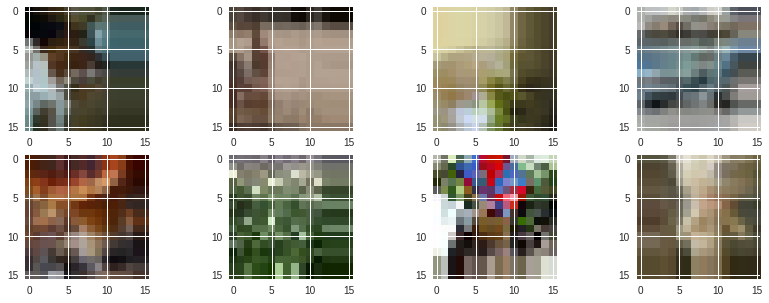

In [15]:
# load data
val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
# input image dimensions
img_rows, img_cols = 16, 16
batch_size=400
#val_data.head(10)
# Use Augmentaion parameters as required.
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True
    )

valid_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(img_rows, img_cols), color_mode='rgb', 
                                                    batch_size=batch_size, class_mode='categorical', shuffle=True, seed=42)
validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(img_rows, img_cols),
                                                    color_mode='rgb', class_mode='categorical', batch_size=batch_size, shuffle=True, seed=42)
x_batch, y_batch = next(train_generator)
x_batch.shape
# Plot Generator images.  ** Re-run the cell to view different set of images.

fig = plt.figure(figsize=(14, 5))

for i in range(8):
    sub = fig.add_subplot(2, 4, i + 1)
    sub.imshow(x_batch[i,:,:], interpolation='nearest')
nb_classes = 200
#nb_epoch = 100
img_channels = 3
model = ResnetBuilder.build_resnet_50_pyramid((img_channels,img_rows,img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
#model.summary()

#model.fit_generator(train_generator, epochs=nb_epoch, steps_per_epoch=200, validation_steps=200, validation_data=validation_generator
##steps_per_epoch=Integer. Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch. 
#It should typically be equal to ceil(num_samples / batch_size) Optional for Sequence: if unspecified, will use the len(generator) as a number of steps.
##validation_steps=Only relevant if validation_data is a generator. Total number of steps (batches of samples) to yield from validation_data generator before stopping at the end of every epoch. 
#It should typically be equal to the number of samples of your validation dataset divided by the batch size. Optional for Sequence: if unspecified, will use the len(validation_data) as a number of steps.
##epochs: Integer. Number of epochs to train the model. An epoch is an iteration over the entire data provided, as defined by steps_per_epoch. 
#Note that in conjunction with initial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations given by epochs,
#but merely until the epoch of index epochs is reached.
#steps_per_epoch=100000/200=500
#validation_steps=10000/200=50
#nb_epoch = 100
# checkpoint
#filepath="./tiny-imagenet-200/weights.best.hdf5"
model.load_weights(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

nb_epoch = 5
model.fit_generator(train_generator, epochs=nb_epoch, steps_per_epoch=500, validation_steps=50, validation_data=validation_generator, callbacks=callbacks_list)

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 1/5
500/500 [==============================] - 792s 2s/step - loss: 2.6020 - acc: 0.4254 - val_loss: 2.7623 - val_acc: 0.3740

Epoch 00001: val_acc improved from -inf to 0.37400, saving model to drive/app/weights.best.hdf5
Epoch 2/5
500/500 [==============================] - 778s 2s/step - loss: 2.2293 - acc: 0.4896 - val_loss: 2.5799 - val_acc: 0.4068

Epoch 00002: val_acc improved from 0.37400 to 0.40680, saving model to drive/app/weights.best.hdf5
Epoch 3/5
500/500 [==============================] - 778s 2s/step - loss: 2.1094 - acc: 0.5102 - val_loss: 2.6377 - val_acc: 0.4004

Epoch 00003: val_acc did not improve from 0.40680
Epoch 4/5
500/500 [==============================] - 778s 2s/step - loss: 2.0614 - acc: 0.5220 - val_loss: 2.4735 - val_acc: 0.4404

Epoch 00004: val_acc improved from 0.40680 to 0.44040, saving model to drive/app/weights.best.hdf5
Epoch 5/5
500/500 [==============

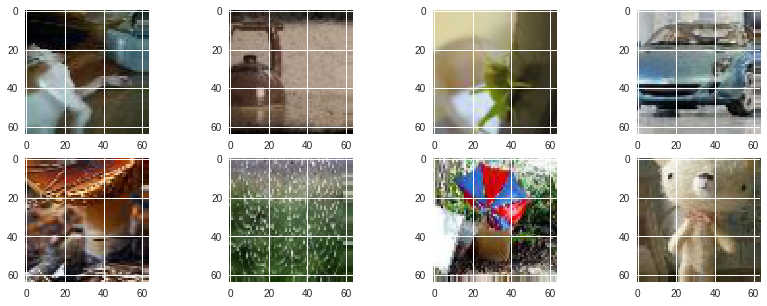

In [16]:
# load data
val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
# input image dimensions
img_rows, img_cols = 64, 64
batch_size=50
#val_data.head(10)
# Use Augmentaion parameters as required.
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
    )

valid_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(img_rows, img_cols), color_mode='rgb', 
                                                    batch_size=batch_size, class_mode='categorical', shuffle=True, seed=42)
validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(img_rows, img_cols),
                                                    color_mode='rgb', class_mode='categorical', batch_size=batch_size, shuffle=True, seed=42)
x_batch, y_batch = next(train_generator)
x_batch.shape
# Plot Generator images.  ** Re-run the cell to view different set of images.

fig = plt.figure(figsize=(14, 5))

for i in range(8):
    sub = fig.add_subplot(2, 4, i + 1)
    sub.imshow(x_batch[i,:,:], interpolation='nearest')
nb_classes = 200
#nb_epoch = 100
img_channels = 3
model = ResnetBuilder.build_resnet_50_pyramid((img_channels,img_rows,img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
#model.summary()

#model.fit_generator(train_generator, ep`ochs=nb_epoch, steps_per_epoch=200, validation_steps=200, validation_data=validation_generator
##steps_per_epoch=Integer. Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch. 
#It should typically be equal to ceil(num_samples / batch_size) Optional for Sequence: if unspecified, will use the len(generator) as a number of steps.
##validation_steps=Only relevant if validation_data is a generator. Total number of steps (batches of samples) to yield from validation_data generator before stopping at the end of every epoch. 
#It should typically be equal to the number of samples of your validation dataset divided by the batch size. Optional for Sequence: if unspecified, will use the len(validation_data) as a number of steps.
##epochs: Integer. Number of epochs to train the model. An epoch is an iteration over the entire data provided, as defined by steps_per_epoch. 
#Note that in conjunction with initial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations given by epochs,
#but merely until the epoch of index epochs is reached.
#steps_per_epoch=100000/200=500
#validation_steps=10000/200=50
#nb_epoch = 100
# checkpoint
#filepath="./tiny-imagenet-200/weights.best.hdf5"
model.load_weights(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

nb_epoch = 5
model.fit_generator(train_generator, epochs=nb_epoch, steps_per_epoch=500, validation_steps=50, validation_data=validation_generator, callbacks=callbacks_list)

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
500/500 [==============================] - 344s 688ms/step - loss: 2.2054 - acc: 0.4679 - val_loss: 3.9473 - val_acc: 0.2949

Epoch 00001: val_acc improved from -inf to 0.29490, saving model to drive/app/weights.best.hdf5
Epoch 2/5
500/500 [==============================] - 326s 651ms/step - loss: 1.3583 - acc: 0.6415 - val_loss: 3.9153 - val_acc: 0.2993

Epoch 00002: val_acc improved from 0.29490 to 0.29930, saving model to drive/app/weights.best.hdf5
Epoch 3/5
500/500 [==============================] - 327s 655ms/step - loss: 1.2543 - acc: 0.6672 - val_loss: 4.0033 - val_acc: 0.3176

Epoch 00003: val_acc improved from 0.29930 to 0.31760, saving model to drive/app/weights.best.hdf5
Epoch 4/5
500/500 [==============================] - 329s 657ms/step - loss: 1.3323 - a

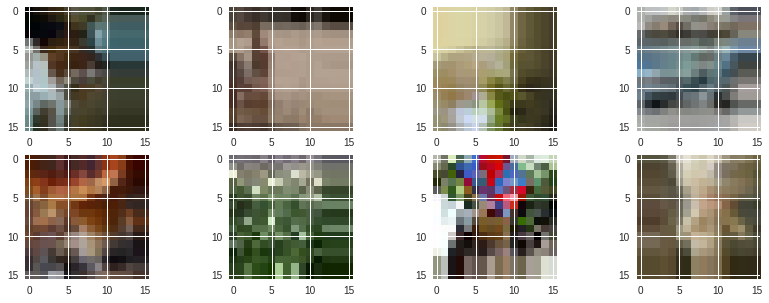

In [6]:
# load data
val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
# input image dimensions
img_rows, img_cols = 16, 16
batch_size=400
#val_data.head(10)
# Use Augmentaion parameters as required.
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True
    )

valid_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(img_rows, img_cols), color_mode='rgb', 
                                                    batch_size=batch_size, class_mode='categorical', shuffle=True, seed=42)
validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(img_rows, img_cols),
                                                    color_mode='rgb', class_mode='categorical', batch_size=batch_size, shuffle=True, seed=42)
x_batch, y_batch = next(train_generator)
x_batch.shape
# Plot Generator images.  ** Re-run the cell to view different set of images.

fig = plt.figure(figsize=(14, 5))

for i in range(8):
    sub = fig.add_subplot(2, 4, i + 1)
    sub.imshow(x_batch[i,:,:], interpolation='nearest')
nb_classes = 200
#nb_epoch = 100
img_channels = 3
model = ResnetBuilder.build_resnet_50_pyramid((img_channels,img_rows,img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
#model.summary()

#model.fit_generator(train_generator, epochs=nb_epoch, steps_per_epoch=200, validation_steps=200, validation_data=validation_generator
##steps_per_epoch=Integer. Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch. 
#It should typically be equal to ceil(num_samples / batch_size) Optional for Sequence: if unspecified, will use the len(generator) as a number of steps.
##validation_steps=Only relevant if validation_data is a generator. Total number of steps (batches of samples) to yield from validation_data generator before stopping at the end of every epoch. 
#It should typically be equal to the number of samples of your validation dataset divided by the batch size. Optional for Sequence: if unspecified, will use the len(validation_data) as a number of steps.
##epochs: Integer. Number of epochs to train the model. An epoch is an iteration over the entire data provided, as defined by steps_per_epoch. 
#Note that in conjunction with initial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations given by epochs,
#but merely until the epoch of index epochs is reached.
#steps_per_epoch=100000/200=500
#validation_steps=10000/200=50
#nb_epoch = 100
# checkpoint
#filepath="./tiny-imagenet-200/weights.best.hdf5"
model.load_weights(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

nb_epoch = 5
model.fit_generator(train_generator, epochs=nb_epoch, steps_per_epoch=500, validation_steps=50, validation_data=validation_generator, callbacks=callbacks_list)

In [0]:
# load data
val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
# input image dimensions
img_rows, img_cols = 64, 64
batch_size=50
#val_data.head(10)
# Use Augmentaion parameters as required.
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
    )

valid_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(img_rows, img_cols), color_mode='rgb', 
                                                    batch_size=batch_size, class_mode='categorical', shuffle=True, seed=42)
validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(img_rows, img_cols),
                                                    color_mode='rgb', class_mode='categorical', batch_size=batch_size, shuffle=True, seed=42)
x_batch, y_batch = next(train_generator)
x_batch.shape
# Plot Generator images.  ** Re-run the cell to view different set of images.

fig = plt.figure(figsize=(14, 5))

for i in range(8):
    sub = fig.add_subplot(2, 4, i + 1)
    sub.imshow(x_batch[i,:,:], interpolation='nearest')
nb_classes = 200
#nb_epoch = 100
img_channels = 3
model = ResnetBuilder.build_resnet_50_pyramid((img_channels,img_rows,img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
#model.summary()

#model.fit_generator(train_generator, ep`ochs=nb_epoch, steps_per_epoch=200, validation_steps=200, validation_data=validation_generator
##steps_per_epoch=Integer. Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch. 
#It should typically be equal to ceil(num_samples / batch_size) Optional for Sequence: if unspecified, will use the len(generator) as a number of steps.
##validation_steps=Only relevant if validation_data is a generator. Total number of steps (batches of samples) to yield from validation_data generator before stopping at the end of every epoch. 
#It should typically be equal to the number of samples of your validation dataset divided by the batch size. Optional for Sequence: if unspecified, will use the len(validation_data) as a number of steps.
##epochs: Integer. Number of epochs to train the model. An epoch is an iteration over the entire data provided, as defined by steps_per_epoch. 
#Note that in conjunction with initial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations given by epochs,
#but merely until the epoch of index epochs is reached.
#steps_per_epoch=100000/200=500
#validation_steps=10000/200=50
#nb_epoch = 100
# checkpoint
#filepath="./tiny-imagenet-200/weights.best.hdf5"
model.load_weights(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

nb_epoch = 10
model.fit_generator(train_generator, epochs=nb_epoch, steps_per_epoch=500, validation_steps=50, validation_data=validation_generator, callbacks=callbacks_list)

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Epoch 1/10
500/500 [==============================] - 740s 1s/step - loss: 1.7923 - acc: 0.6106 - val_loss: 2.8277 - val_acc: 0.3772

Epoch 00001: val_acc improved from -inf to 0.37720, saving model to drive/app/weights.best.hdf5
Epoch 2/10
500/500 [==============================] - 723s 1s/step - loss: 1.4659 - acc: 0.6747 - val_loss: 2.5708 - val_acc: 0.4288

Epoch 00002: val_acc improved from 0.37720 to 0.42880, saving model to drive/app/weights.best.hdf5
Epoch 3/10
500/500 [==============================] - 726s 1s/step - loss: 1.3665 - acc: 0.6954 - val_loss: 2.2928 - val_acc: 0.4724

Epoch 00003: val_acc improved from 0.42880 to 0.47240, saving model to drive/app/weights.best.hdf5
Epoch 4/10
500/500 [==============================] - 725s 1s/step - loss: 1.3209 - acc: 0.7064 - val_loss: 2.3183 - val_acc: 0.4784

Epoch 00004: val_acc improved from 0.47240 to 0.47840, saving model to drive/ap

In [0]:
# load data
val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
# input image dimensions
img_rows, img_cols = 64, 64
batch_size=50
#val_data.head(10)
# Use Augmentaion parameters as required.
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    zoom_range = 0.1,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True
    )

valid_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(img_rows, img_cols), color_mode='rgb', 
                                                    batch_size=batch_size, class_mode='categorical', shuffle=True, seed=42)
validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(img_rows, img_cols),
                                                    color_mode='rgb', class_mode='categorical', batch_size=batch_size, shuffle=True, seed=42)
x_batch, y_batch = next(train_generator)
x_batch.shape
# Plot Generator images.  ** Re-run the cell to view different set of images.

fig = plt.figure(figsize=(14, 5))

for i in range(8):
    sub = fig.add_subplot(2, 4, i + 1)
    sub.imshow(x_batch[i,:,:], interpolation='nearest')
nb_classes = 200
#nb_epoch = 100
img_channels = 3
model = ResnetBuilder.build_resnet_50_pyramid((img_channels,img_rows,img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
#model.summary()

#model.fit_generator(train_generator, ep`ochs=nb_epoch, steps_per_epoch=200, validation_steps=200, validation_data=validation_generator
##steps_per_epoch=Integer. Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch. 
#It should typically be equal to ceil(num_samples / batch_size) Optional for Sequence: if unspecified, will use the len(generator) as a number of steps.
##validation_steps=Only relevant if validation_data is a generator. Total number of steps (batches of samples) to yield from validation_data generator before stopping at the end of every epoch. 
#It should typically be equal to the number of samples of your validation dataset divided by the batch size. Optional for Sequence: if unspecified, will use the len(validation_data) as a number of steps.
##epochs: Integer. Number of epochs to train the model. An epoch is an iteration over the entire data provided, as defined by steps_per_epoch. 
#Note that in conjunction with initial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations given by epochs,
#but merely until the epoch of index epochs is reached.
#steps_per_epoch=100000/200=500
#validation_steps=10000/200=50
#nb_epoch = 100
# checkpoint
#filepath="./tiny-imagenet-200/weights.best.hdf5"
model.load_weights(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

nb_epoch = 15
model.fit_generator(train_generator, epochs=nb_epoch, steps_per_epoch=500, validation_steps=50, validation_data=validation_generator, callbacks=callbacks_list)

In [0]:
filepath="./tiny-imagenet-200/weights.best.hdf5"
print("Saved the model to disk")
from google.colab import files

files.download(filepath)

In [0]:
# load data
val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
# input image dimensions
img_rows, img_cols = 64, 64
batch_size=50
#val_data.head(10)
# Use Augmentaion parameters as required.
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    zoom_range = 0.2,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True
    )

valid_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(img_rows, img_cols), color_mode='rgb', 
                                                    batch_size=batch_size, class_mode='categorical', shuffle=True, seed=42)
validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(img_rows, img_cols),
                                                    color_mode='rgb', class_mode='categorical', batch_size=batch_size, shuffle=True, seed=42)
x_batch, y_batch = next(train_generator)
x_batch.shape
# Plot Generator images.  ** Re-run the cell to view different set of images.

fig = plt.figure(figsize=(14, 5))

for i in range(8):
    sub = fig.add_subplot(2, 4, i + 1)
    sub.imshow(x_batch[i,:,:], interpolation='nearest')
nb_classes = 200
#nb_epoch = 100
img_channels = 3
model = ResnetBuilder.build_resnet_50_pyramid((img_channels,img_rows,img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
#model.summary()

#model.fit_generator(train_generator, ep`ochs=nb_epoch, steps_per_epoch=200, validation_steps=200, validation_data=validation_generator
##steps_per_epoch=Integer. Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch. 
#It should typically be equal to ceil(num_samples / batch_size) Optional for Sequence: if unspecified, will use the len(generator) as a number of steps.
##validation_steps=Only relevant if validation_data is a generator. Total number of steps (batches of samples) to yield from validation_data generator before stopping at the end of every epoch. 
#It should typically be equal to the number of samples of your validation dataset divided by the batch size. Optional for Sequence: if unspecified, will use the len(validation_data) as a number of steps.
##epochs: Integer. Number of epochs to train the model. An epoch is an iteration over the entire data provided, as defined by steps_per_epoch. 
#Note that in conjunction with initial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations given by epochs,
#but merely until the epoch of index epochs is reached.
#steps_per_epoch=100000/200=500
#validation_steps=10000/200=50
#nb_epoch = 100
# checkpoint
#filepath="./tiny-imagenet-200/weights.best.hdf5"
model.load_weights(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

nb_epoch = 15
model.fit_generator(train_generator, epochs=nb_epoch, steps_per_epoch=500, validation_steps=50, validation_data=validation_generator, callbacks=callbacks_list)

In [0]:
#filepath="drive/app/weights.best.hdf5"
print("Saved the model to disk")
from google.colab import files

files.download(filepath)